### set up

In [2]:
import os
path1 = 'C:\\Users\\BSE\\Documents\\MaxVonMylius\\GeographyGrowth\\TermPaper\\py'
path2 = 'C:\\Users\\mmyli\\Documents\\HumboldtUni\\GeographyGrowth\\Paper\\shadow_projection_2D'
path = path1 if os.path.isdir(path1) else path2
os.chdir(path)

import numpy as np
import geopandas as gpd
from geopandas import GeoSeries
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.affinity import translate, scale
from shapely.ops import cascaded_union
from pysolar import solar
from datetime import datetime
import math
import pytz

# Define helper functions

### Learnings:
#### Speeding up code:
- accessing coords like poly.exterior.coords is very costly
- convention: 
    - exterior should be defined counter-clockwise, 
    - interiors should be defined clockwise

## Smaller helper methods

In [3]:
def definedClockwise (coords):
    """
    return whether coords are defined clockwise
    """
    if not coords[0] == coords[-1]:
        coords = coords + [coords[0]]
    
    return sum([(coords[(i+1)%len(coords)][0]-coords[i][0])*(coords[(i+1)%len(coords)][1]+coords[i][1]) for i in range(len(coords))])>0

In [7]:
def noDoubleCoords (coords):
    """
    Function that clean coordinates such a coordinate that directly follows itself is removed
    """
    return [coords[i] for i in range(len(coords)) if not coords[i] == coords[(i+1)%len(coords)]]

In [10]:
def inclusiveSplit (l:list, i:int, j:int, both:bool=True):
    """
    if both not true it will only return the part in between i and j
    comments below show logic. code is more compact
    """
    
    if both:
        return \
            [\
            (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i<=j else (l[max(i,j):] +l[:min(i,j)+1]), 
            (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i>j else (l[max(i,j):] +l[:min(i,j)+1])\
            ]
    
    if i<=j:
        return (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i<=j else (l[max(i,j):] +l[:min(i,j)+1])
        
    return (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i>j else (l[max(i,j):] +l[:min(i,j)+1])
    
# x, y = min(i,j), max(i,j)
# partA = l[x : y+1] + ([] if (y<len(l)) else [l[0]])
# partB = l[y:] +l[:x+1]
# if i<=j:
#     part1 = partA
#     part2 = partB
# else:
#     part1 = partB
#     part2 = partA
# if both:
#     return [part1, part2]
# else:
#     return part1

In [34]:
def sideOfVector (point:tuple, vectorEnd:tuple, vectorBase:tuple=(0,0)):
    """
    check whether point is on left or ride side of vector
    does not distinguish between <0 and ==0.
    """
    return \
        (\
        (point[0]-vectorBase[0])*(vectorEnd[1]-vectorBase[1]) - \
        (point[1]-vectorBase[1])*(vectorEnd[0]-vectorBase[0])\
        )>0

In [58]:
def inSide(c_1:tuple, c0:tuple, c1:tuple):
        """
        c_1, c0, c1 are subsequent coordinates from a polygon defined in counter clockwise manner 
        check whether point c0 would lie inside of the polygon if it was defined without coordinate c0 connecting c_1 directly to c1
        if no point is inside the polygon is convex
        False if not inside True if inside
        Point on line is not considered inside.
        """
        
        return True if (c1[0] - c_1[0])*(c0[1] - c_1[1]) - (c1[1] - c_1[1])*(c0[0] - c_1[0]) < 0 else False
        

## Functions to create random Polygons

In [119]:
math.log(3)

1.0986122886681098

In [120]:
def createPolygon (n_edges:int, interiors:list=[], scale:int=1, shift:tuple=(0,0), convex:bool=True, regular:bool=True) -> Polygon:
    """
    creates and returns a Polygon based on the parameters given
    Polygon coordinates are points from the unit circle
    if regular == True, then all edges have same length, and all angle are equal 

    """
    if n_edges<3:
        raise ValueError('n_edges edeges must be at least 3 to create a polygon. n_edges was '+ str(n_edges))
    
    scaleNonConvex = [1 for n in range(n_edges)] if convex else [(np.random.random()*2+0.5)/2.5 for n in range(n_edges)]
    rndm = [np.random.random()**math.log(n_edges)+0.1 for n in range(n_edges)]
    scaleNonReguar = [n/n_edges for n in range(n_edges)] if regular else [sum(rndm[:n])/sum(rndm) for n in range(n_edges)]
    # print(scaleNonReguar)
    coords = [(\
        shift[0]+scaleNonConvex[i]*scale*math.sin(scaleNonReguar[i] * 360 * math.pi / 180 ),\
        shift[1]+scaleNonConvex[i]*scale*math.cos(scaleNonReguar[i] * 360 * math.pi / 180 ) \
        ) for i in range(n_edges)]
    
    splitAt = np.random.randint(n_edges+1)
    coords = coords[:splitAt] + coords[splitAt:]

    if definedClockwise(coords):
        coords.reverse()
    
    for interior in interiors:
        if not definedClockwise(interior):
            interior.reverse()

    return Polygon(coords, interiors)    

In [5]:
def createConvexPolygon (n_edges:int, interiors:list=[], scale:int=1, shift:tuple=(0,0), regular:bool=True) -> Polygon:
    """
    creates and returns a Polygon based on the parameters given
    Polygon coordinates are points from the unit circle
    if regular == True, then all edges have same length, and all angle are equal 

    """
    return createPolygon(n_edges=n_edges, interiors=interiors, scale=scale, shift=shift, convex=True, regular=regular)
    

In [6]:
def createPolygonWithInteriors(n_edges:int=3, n_interiors:int=0, n_edges_interiors:int=3, regular:bool=True, convex:bool=True, convexInteriors:bool=True, max_iterations:int=10) -> Polygon:
    if regular:
        return createPolygon(n_edges, \
            interiors=[[\
            createPolygon(n_edges=n_edges_interiors, scale=1/(n*5), shift=(1/(n+2)*(i+1)-0.5*n/(n+1),0), \
                regular=regular, convex=convexInteriors).exterior for i in list(range(n))] for n in [n_interiors]][0],\
            convex=convex)
    
    # randomly create wholes within shape
    interiors = []
    interiorCenterCoords = []
    interiorScale = 1/(.25+math.log(n_interiors+3))
    interiorScales = [interiorScale]

    r = np.random.random()
    n_edges_irregular = n_edges#int(2*(n_edges-3)*r+3)
    poly = createPolygon(n_edges_irregular, regular=regular, convex=convex)
    extCoords = poly.exterior.coords
    maxmax=2**n_interiors * 1000
    m=0
    for j in range(n_interiors):
        iteration = 0
        while len(interiors)-1 < j:
            # try different points in this
            if iteration == 0:
                boundingPoly = Polygon( [( (1-interiorScale)*coord[0], (1-interiorScale)*coord[1] ) for coord in extCoords] )
                interiorBounds = [ Polygon([ ( (1+interiorScale)*interiorScales[i]*(coord[0] - interiorCenterCoords[i][0]) + interiorCenterCoords[i][0], \
                    (1+interiorScale)*interiorScales[i]*(coord[1] - interiorCenterCoords[i][1]) + interiorCenterCoords[i][1] ) \
                    for coord in interiors[i]]) for i in range(len(interiors))]
                # bounds = (minx, miny, maxx, maxy)
                bounds = boundingPoly.bounds
            #
            
            # find random point within Polygon (but at some distance of edges)
            p = Point(bounds[0]-1, bounds[1]-1)
            
            while not (boundingPoly.contains(p) and not any([ib.contains(p) for ib in interiorBounds])):
                p = Point((bounds[2]-bounds[0])*np.random.random()+bounds[0], (bounds[3]-bounds[1])*np.random.random()+bounds[1])
                
                m+=1
                if maxmax == m:
                    print("bounds",bounds)
                    print("boundingPoly",list(boundingPoly.exterior.coords))
                    print("p.coords", p.coords[0])
                    print("boundingPoly.contains(p)",boundingPoly.contains(p))
                    print("interiorBounds",interiorBounds)
                    print("m",m)
                    GeoSeries([poly, boundingPoly] + interiorBounds).plot(cmap="viridis", alpha=0.4, edgecolor="black")
                    return
            
            r = np.random.random()
            n_edges_interiors_irregular = int(2*(n_edges_interiors-3)*r+3)
            interior = createPolygon(n_edges=n_edges_interiors_irregular, scale=interiorScale, shift=list(p.coords)[0], regular=regular, convex=convexInteriors).exterior
            
            if poly.contains(interior):
                interiorCoords = list(interior.coords)
                if not definedClockwise(interiorCoords):
                    interiorCoords.reverse()
                interiors.append(interiorCoords)
                poly = Polygon(extCoords, [x for x in interiors])
                interiorScales.append(interiorScale)
                interiorCenterCoords.append(p.coords[0])
                iteration = 0
            else:
                if iteration == max_iterations - 1:
                    interiorScale *= 0.9*(1-m/maxmax)**2 
                iteration = (iteration+1) % max_iterations
        #
    #
    return poly


## Methods to validate Polygons

In [14]:
def splitToValidCoordinateRings (arr) -> list:
    """
    inputs:
    arr: list of coordinate [(0,0),(1,1),...]
    Function splits list of potentially invalid coordinate rings into array valid coordinate rings 
    Such that each coordinate ring does never intersect the same coordinate twice 
    E.g. a shape like the number 8 does drawn as a line would be split into two rings (upper and lower o-shape)
    Further the functions simplifies [x,y,y,z,x] to [x,y,z]
    ### 2d0 the logic is bad! rethink that it should divide instead of splitting coord rings
    
    """
    # print("arr0", arr)
    arr = [arr[i] for i in range(len(arr)) if not arr[i] == arr[(i+1)%len(arr)]]
    # print("initail",arr)
    if len(arr)==len(set(arr)):
        # print("early return", arr)
        return [arr]
    maxEl = max(set(arr), key=arr.count)
    arr = arr[(arr.index(maxEl)+1)%len(arr):] + arr[:(arr.index(maxEl)+1)%len(arr)]
    # print("not early return",arr)
    splitIndices = [0]+[i for i, x in enumerate(arr) if x == maxEl]
    # print("splitIndices",splitIndices)
    # res = [[item for sublist in \
    #     splitToValidCoordinateRings(arr[splitIndices[i]:splitIndices[i+1]+1])\
    #     for item in sublist]\
    #     for i in range(len(splitIndices)-1)]
    validDivison = False
    i=0
    while not validDivison:
        splitIndices[i]+1
    print("res0", arr)
    res = [
        arr[splitIndices[i]:splitIndices[i+1]+1]\
        for i in range(len(splitIndices)-1)] 
    print("res1", res)
    
    res = [[a[i] for i in range(len(a)) if not a[i] == a[(i+1)%len(a)]] \
        for a in \
        res]
    # here make the split
        
    [arr for arr in res]

    print("res2",res)
    res = [b if len(b)==len(set(b)) else splitToValidCoordinateRings(b) \
        for b in \
        res]
    print("res3",res)

    # res = [b if len(b)==len(set(b)) else splitToValidCoordinateRings(b) \
    #     for b in \
    #     [[item for sublist in \
    #     arr[splitIndices[i]:splitIndices[i+1]+1]\
    #     for item in sublist]\
    #     for i in range(len(splitIndices)-1)]]

    print("res",res)
    return res

In [15]:
def addSelfIntersectingCoords(coords) -> list:
    """
    inputs:
    coords = list of coordinates
    """
    edges = [LineString(coords[k:k+2]) for k in range(len(coords) - 1)]
    # 2do check that sorted sorts in correct order
    coordsWithIntersectionPoints = \
        [item for sublist in [[coords[i]]+\
        [item for sublist in \
        [sorted(list(edges[i].intersection(edges[j]).coords),\
        key=lambda intersec: abs(coords[i][0]-intersec[0] + coords[i][1]-intersec[1]))\
        for j in range(len(edges))if not i == j and edges[i].crosses(edges[j])] \
        for item in sublist] \
        for i in range(len(coords)-1)] \
        for item in sublist]
    # print("coordsWithIntersectionPoints",coordsWithIntersectionPoints)
    return coordsWithIntersectionPoints

In [16]:
# # 2do create a function that make invalid polygons valid
# def makePolygonValid (poly:Polygon) -> list:
#     """
#     return polygon as list of valid polygons
#     """
#     [x for x in ]
#     Polygon()

#     if type(poly.boundary)==LineString or not poly.is_valid:
#         # split polygon into valid parts
#         coords = poly.boundary.coords # 2do maybe the intersections are not visible from points
#         print("poly.boundary.coords", list(poly.boundary.coords))
#         triangleList = \
#             [\
#                 [item for sublist in \
#                     triangularize(Polygon(\
#                         coordRing, \
#                         [[item for sublist in splitToValidCoordinateRings(addSelfIntersectingCoords(list(interior.coords))) for item in sublist] \
#                         for interior in poly.interiors if Polygon(coordRing).contains(interior)]\
#                     )) \
#                 for item in sublist]\
#             for coordRing in splitToValidCoordinateRings(addSelfIntersectingCoords(coords))]
#         print("after invalid shape:",triangleList)
#         # return triangleList
        
#     return []

In [36]:
# addSelfIntersectingCoords([(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5)])

In [37]:
# splitToValidCoordinateRings([(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5)])

# Methods to divide Polyogons into forms from which it is easier to project shadows

### Method to divide polygon with interiors to list of polygons without interiors

In [8]:
def splitAtInteriors (poly:Polygon, plot=False) -> list:
    """
    convert any polygon to array of polygons that do not cotaining any interiors
    
    All coord rings are made counter-clockwise

    Assumption: 
    for each polygon with interiors there exist an interior with points j and j0 for j != j0
    that you can connect with a valid line from to j the exterior point k and from j0 to k0 for k != k0
    """
    interiors = poly.interiors
    # early return if no interiors
    if len(interiors) == 0:
        return [poly]
    
    polyExterior = poly.exterior
    extCoords = noDoubleCoords(polyExterior.coords)
    interiorsCoords = [noDoubleCoords(interior.coords) for interior in interiors]
    
    if definedClockwise(extCoords):
        extCoords.reverse()
                        
    i = 0
    while i < len(interiors):
        if not definedClockwise(interiorsCoords[i]):
            interiorsCoords[i].reverse()
        # store here the indices j0/j at which interior shall be split and k0/k to split exterior
        j, j0, k0, line0 = 0, -1, -1, -1
        
        # stop trying for interior i as soon as you can't connect two seperate coordinates to exterior 
        while j < len(interiorsCoords[i]) - (k0 == -1):
            k = 0
            while k < len(extCoords) and not j == j0:
                
                line = LineString([interiorsCoords[i][j], extCoords[k]])
                
                # perform multiple checks whether line from interior to exterior shall be chosen
                # line.intersects(edge) and not line.touches(edge) handles case where line partly overlays with edge but doesn't cross
                if \
                    k != k0 \
                    and poly.contains(line) \
                    and not (k0 != -1 and (line.intersects(line0) or line.touches(line0)) )\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([interiorsCoords[i][n], interiorsCoords[i][(n+1)%len(interiorsCoords[i])]]) for n in range(len(interiorsCoords[i]))]])\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([extCoords[n], extCoords[n+1]]) for n in range(len(extCoords)-1)]]):
                    
                    if k0 == -1:
                        j0, k0, line0 = j, k, line
                        # reset k index such that it will start with 0 in next iteration
                        k = 0
                        continue
                    
                    else:
                        # divide polygon into two parts A and B
                        intA = interiorsCoords[i][j0:j+1]
                        intB = interiorsCoords[i][j:] + interiorsCoords[i][:j0+1]
                        extA = (extCoords[k:] + extCoords[:k0+1]) if k0<k else extCoords[k:k0+1]
                        extB = (extCoords[k0:] + extCoords[:k+1]) if k0>k else extCoords[k0:k+1]

                        polyCoords = [extA + intA, extB + intB ]
                        polygons = [Polygon(coords) for coords in polyCoords]
                        
                        if(plot):
                            fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
                            GeoSeries(polygons).plot(ax=axs, alpha=0.4, cmap="viridis", edgecolor="black")
                            GeoSeries([Point(interiorsCoords[i][j]), Point(interiorsCoords[i][j0]) ]).plot(ax=axs, cmap="tab10", linewidth=3)
                            GeoSeries([Point(extCoords[k]), Point(extCoords[k0]) ]).plot(ax=axs, cmap="tab10", linewidth=3)
                            GeoSeries([line, line0]).plot(ax=axs, cmap="tab10", linewidth=3)
                            for x, y, label in zip([extCoords[x][0] for x in range(len(extCoords))], [extCoords[x][1] for x in range(len(extCoords))], [str(x) for x in range(len(extCoords))]):
                                axs.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                            for x, y, label in zip([interiorsCoords[i][x][0] for x in range(len(interiorsCoords[i]))], [interiorsCoords[i][x][1] for x in range(len(interiorsCoords[i]))], [str(x) for x in range(len(interiorsCoords[i]))]):
                                axs.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                        
                        # early return if just one interior
                        if len(interiors) == 1:
                            return polygons
                        
                        #else check where to nest further
                        polygons = [Polygon(coords,[interiors[n] for n in range(len(interiors)) if not n == i and Polygon(coords).contains(interiors[n])]) for coords in polyCoords]
                        polygons = [item for sublist in [[ply] if len(ply.interiors) == 0 else splitAtInteriors(ply,plot=plot) for ply in polygons] for item in sublist]
                        return polygons
                k += 1
            j += 1
        i += 1
    #

### Divide polygon into triangles

In [17]:
def triangularize(poly:Polygon, lvl:int=0, maxIteration:int=300, plot:bool=True) -> list:
    """
    Function recursively splits a polygon (valid, without interiors) into two parts until the initial polygon is completly divided into triangles
    it returns a list of triangle coordinates
    Inputs: 
    poly = Polygon that will be triangularized. That may Polygon may have any shape and may have multiple holes (=interiors)
    lvl indicates the deepness of the nest
    """
    # handles cases where polygon has holes
    if lvl == 0 and len(poly.interiors)>0:
        #2do validate polygon at this step
        triangleList =  \
            [item for sublist in \
                [triangularize(polyWithoutInteriors) for polyWithoutInteriors in splitAtInteriors(poly, plot)]\
            for item in sublist]
        return triangleList
    # thus from here on polygon does not have any holes by definition
    coords = noDoubleCoords(poly.exterior.coords)
    
    # early return if shape is regular triangle
    if(len(set(coords))<4):
        print("early return", [poly])
        return [poly.exterior.coords]

    line = LineString([coords[0],coords[2]])
    i,j = 0,2
    while i < len(coords):
        line = LineString([coords[i],coords[j%len(coords)]])
        if(j < len(coords)):
            if poly.contains(line):
                coordRings = [coords[i:j+1], coords[i:i+1]+coords[j:]]
                coordRings = [coords[i:j+1], coords[:i+1]+coords[j:]]\
                    if i<j else \
                    [coords[j:i+1], coords[:j+1]+coords[i:]]
                
                listOfCoordRings = []
                for coordRing in coordRings:
                    if len(coordRing)>3:
                        res = triangularize(poly=Polygon(coordRing), lvl=lvl+1,maxIteration=maxIteration, plot=plot)
                    else:
                        res = [coordRing]
                    # print("res",res)
                    listOfCoordRings.extend(res)
                
                if(plot and lvl==0):
                    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
                    GeoSeries([poly]).plot(ax=axs, color = "white", edgecolor="black", linewidth=4)
                    GeoSeries([Polygon(x) for x in listOfCoordRings]).plot(ax=axs, alpha=0.6, cmap = "viridis", edgecolor="black")
            
                return listOfCoordRings
            j += 1
            #
        else:
            i += 1
            j = i+2
        #
    #
    raise KeyError("triangularize did not return anything. Check if coorect input was given.", i, j, coords)
    #
#

### Method to divide polygon into list of convex polygons

In [20]:
def splitToConvex (poly:Polygon, plot:bool=True)->list:
    """
    Input: list of exterior coords for a polygon 
    returns list of lists of coordinates for convex polygons that in combination represent initial polygon
    """
    coords = noDoubleCoords(poly.exterior.coords)
    
    z1 = [i for i in range(len(coords)) if inSide(coords[(i-1)%len(coords)], coords[i], coords[(i+1)%len(coords)])]
    
    # early returns:
    if len(z1) == 0:
        listOfCoords =  [coords]
        return listOfCoords
    if len(z1) == 1:
        listOfCoords = inclusiveSplit(coords, z1[0], (z1[0]+2)%len(coords))
        return listOfCoords
    if len(z1) == 2:
        if z1[0] == z1[1]-1 or z1[0] == (z1[1]+1)%len(coords):
            m = 2*(z1[0] == z1[1]-1)-1
            it=0
            kA = (z1[0] - 2)%len(coords)
            while not kA == z1[1] and it<1000:
                if poly.contains( LineString([coords[kA],coords[z1[0]]]) ):
                    partA = inclusiveSplit(coords, kA, z1[0], False)
                    
                    break    
                kA = (kA-1)%len(coords)
                it+=1
            kB = kA
            while not kA == z1[0] and it<1000:
                if poly.contains(LineString([coords[kB],coords[z1[1]]])):
                    partB = inclusiveSplit(coords, z1[1], kB, False)
                    
                    break    
                kB = (kB+1)%len(coords)
                it+=1
            partC = inclusiveSplit(coords, kB, kA, False) + [coords[z1[0]], coords[z1[1]]]
            
            
            listOfCoords = [partA, partB] + splitToConvex(Polygon(partC), plot=plot)
            return listOfCoords

        listOfCoords = inclusiveSplit(coords, z1[0], z1[1])
        return listOfCoords
    
    lines = []
    zc = [0 for i in range(len(coords))]
    coordRings = []
    i, it = 0,0
    while i < len(z1)-1 and it <10000:
        d = 2
        while i+d < len(z1)+1:
            newLine = LineString([coords[z1[i]], coords[z1[(i+d)%len(z1)]]])

            if poly.contains(newLine):
                lines.append(newLine)
                coordRing = inclusiveSplit(coords, z1[i], z1[(i+d)%len(z1)], False)
                
                coordRings.append(coordRing)
                zc[z1[i]] += 1
                zc[z1[(i+d)%len(z1)]] += 1
                
                i = i+d
                break

            else:
                d += 1
        #
        it+=1
    
    # if the first coordinate is not connected to last or second last
    if zc[0] < 2:
        newLine = LineString([coords[z1[0]], coords[z1[-1]]])
        if poly.contains(newLine):
            lines.append(newLine)
            coordRing = inclusiveSplit(coords, z1[-1], z1[0], False)
            coordRings.append(coordRing)
            zc[0] += 1 
            zc[-1] += 1
    
    if len(lines) == 0:
        k=0
        while len(lines) == 0 and k < len(z1):
            m=0
            while len(lines) == 0 and m < len(coords):
                if not m in [(z1[k]-1)%len(coords), z1[k], (z1[k]+1)%len(coords)]:    
                    newLine = LineString([coords[z1[k]], coords[m]])
                    if(poly.contains(newLine)):
                        lines.append(newLine)
                        coordRings = inclusiveSplit(coords, z1[k], m)
                        coordList = [item for sublist in [splitToConvex(Polygon(coordRing), plot=plot) if len(coordRing) > 3 else [coordRing] for coordRing in coordRings]for item in sublist]
                        return coordList
                m += 1
            k += 1
    #
    innerAreaCoords = [xy for i,xy in enumerate(coords) if zc[i]>1]
    
    
    
    listOfCoords = [item for sublist in [splitToConvex(Polygon(coordRing), plot=plot) if len(coordRing) > 3 else [coordRing] for coordRing in coordRings]for item in sublist]
    
    
    if len(innerAreaCoords)>2:
        additionalCoords = splitToConvex(Polygon(innerAreaCoords), plot=plot)
        listOfCoords.extend(additionalCoords)
    
    return listOfCoords

    

## Project shadows
#### preprocess polygon
1. into polygons without holes
2. into either a) triangles or b) convex polygons


### create shadow for convex polygon

In [82]:
def projectConvexShadow (coords:shapely.coords.CoordinateSequence or list, v:tuple)->Polygon:
    """
    Inputs:
    coords = list of coordinates (tuples)
    v = tuple indicating a vector from origion (0,0) to point(vector)
    returns Polygon(shadowCoords) 
    Idea: 
    A triangle that is projected a long a vector of positive length is alwas transformed into a pentagon
    which consits of all points of orignal triangle and points of triangle shifted with vector 
    excluding one point (the one not left or rightmost in angle direction) from origanal triangle
    if that point is most fast towards vector direction out of the three points of that orig triangle
    else exclude that point from the shifted triangle
    """
    coords = noDoubleCoords(coords)
    
    if definedClockwise:
        coords.reverse()

    if not len(coords) > 2:
        raise ValueError("coords provided to triangle project projectConvexShadow are not of length >2:",len(coords))

    # check how far the coordinates are left or right of base vector 
    offsetOrthogonal = [(coords[i][0])*(v[1])-(coords[i][1])*(v[0]) for i in range(len(coords))]
    minI = offsetOrthogonal.index(min(offsetOrthogonal))
    maxI = offsetOrthogonal.index(max(offsetOrthogonal))
    midI = [i for i in range(3) if not i == minI and not i == maxI][0]

    # check if midI coord lies on the side of half space spanned between minI and maxI coords into which the v points
    
    midISide = sideOfVector(coords[midI], coords[maxI],  coords[minI])
    
    coordsSplitted = inclusiveSplit(coords, maxI, minI)
    # partA = coordsSplitted[0]
    # partB = [(coord[0]+v[0], coord[1]+v[1]) for coord in coordsSplitted[1]]

    # shadowCoords = partA + partB
    
    # poly = Polygon(shadowCoords)
        
    return Polygon(coordsSplitted[0] + [(coord[0]+v[0], coord[1]+v[1]) for coord in coordsSplitted[1]])




### Super method to project shadows for multiple polygons

### combine steps for single shadow projection of any polygon

In [87]:
def projectPolygonShadow (poly:Polygon, shadowVector:tuple, triangleMethod:bool=True, plot:bool=False)->Polygon:
    """
    Function that combines all methods to project polygon shadow
    """
    # 2do validate polygon in the first step
    if not plot:
        if triangleMethod:
            return \
                cascaded_union(\
                    [projectConvexShadow(tc, shadowVector) for tc in \
                        [item for sublist in \
                            [triangularize(splt, plot=plot) for splt in splitAtInteriors(poly, plot=plot)]\
                        for item in sublist]\
                    ]\
                )

        else: 
            return \
                cascaded_union(\
                    [projectConvexShadow(tc, shadowVector) for tc in \
                        [item for sublist in \
                            [splitToConvex(splt, plot=plot) for splt in splitAtInteriors(poly, plot=plot)]\
                        for item in sublist]\
                    ]\
                )
    #

    polyValidated = poly
    splitted = splitAtInteriors(polyValidated, plot=False)
    if triangleMethod:
        convexCoords = [item for sublist in [triangularize(splt, plot=False) for splt in splitted] for item in sublist]
    else:
        convexCoords = [item for sublist in [splitToConvex(splt, plot=False) for splt in splitted] for item in sublist]
    
    shadows = [projectConvexShadow(tc, shadowVector) for tc in convexCoords]
    shadow_union = cascaded_union(shadows)
    convexPolys = [Polygon(cc) for cc in convexCoords]
    
    fig, axs = plt.subplots(nrows = 1, ncols = 6, figsize = (24,6))
    GeoSeries([poly]).plot(ax=axs.flat[0], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=axs.flat[1], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=axs.flat[2], color = "white", edgecolor="black", linewidth=3)
    GeoSeries(splitted).plot(ax=axs.flat[2], cmap="viridis",edgecolor="black")
    GeoSeries([poly]).plot(ax=axs.flat[3], color = "white", edgecolor="black", linewidth=3)
    GeoSeries(convexPolys).plot(ax=axs.flat[3], cmap="viridis",edgecolor="black")
    GeoSeries([poly]).plot(ax=axs.flat[4], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries(shadows).plot(ax=axs.flat[4], alpha=0.7, color = "grey",edgecolor="black")
    GeoSeries(convexPolys).plot(ax=axs.flat[5], color = "pink")
    GeoSeries([shadow_union]).plot(ax=axs.flat[5], alpha=0.7, color = "grey",edgecolor="black", linewidth=3)

    return shadow_union

In [86]:
def getConvexCoords (poly:Polygon, triangleMethod:bool=True, plot:bool=False)->Polygon:
    """
    Function that combines all methods to divide any polygon into convex polygons and return their coordinates
    """
    # 2do validate polygon in the first step
    if not plot:
        if triangleMethod:
            return [triangularize(splt, plot=plot) for splt in splitAtInteriors(poly)]
        else:
            return [splitToConvex(splt, plot=plot) for splt in splitAtInteriors(poly)]
    #

    polyValidated = poly
    splitted = splitAtInteriors(polyValidated, plot=False)
    if triangleMethod:
        listOfConvexCoords = [item for sublist in [triangularize(splt, plot=False) for splt in splitted] for item in sublist]
    else:
        listOfConvexCoords = [item for sublist in [splitToConvex(splt, plot=False) for splt in splitted] for item in sublist]
    
    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (24,6))
    GeoSeries([poly]).plot(ax=axs.flat[0], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=axs.flat[1], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=axs.flat[2], color = "white", edgecolor="black", linewidth=3)
    GeoSeries(splitted).plot(ax=axs.flat[2], cmap="viridis",edgecolor="black")
    GeoSeries([poly]).plot(ax=axs.flat[3], color = "white", edgecolor="black", linewidth=3)
    convexPolys = [Polygon(cc) for cc in listOfConvexCoords]
    GeoSeries(convexPolys).plot(ax=axs.flat[3], cmap="viridis",edgecolor="black")

    return listOfConvexCoords

### Get shadow angle

In [88]:
def getShadowVector (lat, long, date, height):
    
    altitude = solar.get_altitude(
            latitude_deg = lat, 
            longitude_deg = long, 
            when = date
            ) 
    # calculate direction of sunlight at location and date
    azimuth = solar.get_azimuth(
        latitude_deg = lat, 
        longitude_deg = long, 
        when = date
        )
    # length of the shadow
    shadowLengthUnitStick = 1 * math.tan( (90 - altitude) * math.pi / 180)
    shadowLength = height * shadowLengthUnitStick
    
    # remember: azimuth gives direction where sun comes from: 
    # shadow are projected in the opposite direction
    # if azimuth between 0° and 180° positive (= shadow goes east), else negative
    longShare = - math.sin((azimuth) * math.pi / 180)
    # if azimuth between 90° and 270° negative (= shadow goes south) else negative
    latShare = - math.sin((azimuth - 90) * math.pi / 180)
    
    scaleMetersToDegrees = 1 # projection already is in meters
    xoff = shadowLength * longShare / scaleMetersToDegrees
    yoff = shadowLength * latShare / scaleMetersToDegrees
        
    print(date,"alt",altitude, "az", azimuth, "xy",(xoff, yoff))
    return (xoff, yoff)

# Test methods

### Create examplary polygons to test methods on.

In [ ]:
# create some polygons to test functions
polygon_1 = Polygon([(0, 0), (0, 3), (5, 3), (2, 4), (6, 4), (6, 0)], [[(1, 1), (1.5, 1), (1.5, 1.5)], [(2, 1), (2.5, 1), (2.5, 1.5)]])
poly=polygon_1
poly11 = Polygon([(-.5,-.5), (0,.5), (.5,-.5)], [[(-0.1,-0.1),(0.1,0.1),(0.1,-0.1)]])
poly3 = createPolygonWithInteriors(n_edges=5, n_interiors=1, n_edges_interiors=3, regular=True)
poly4 = createPolygonWithInteriors(n_edges=5, n_interiors=1, n_edges_interiors=3, regular=False)
poly5 = createPolygonWithInteriors(n_edges=5, n_interiors=2, n_edges_interiors=4, regular=True)
poly6 = createPolygonWithInteriors(n_edges=5, n_interiors=2, n_edges_interiors=4, regular=False)
poly7 = createPolygonWithInteriors(n_edges=5, n_interiors=3, n_edges_interiors=4, regular=True)
poly8 = createPolygonWithInteriors(n_edges=5, n_interiors=3, n_edges_interiors=4, regular=False)
convexWithInterior = [createPolygonWithInteriors(n_edges=3+np.random.randint(10), n_interiors=1+np.random.randint(10), n_edges_interiors=3+np.random.randint(5), regular=False) for i in range(50)]

### test splitAtInteriors function

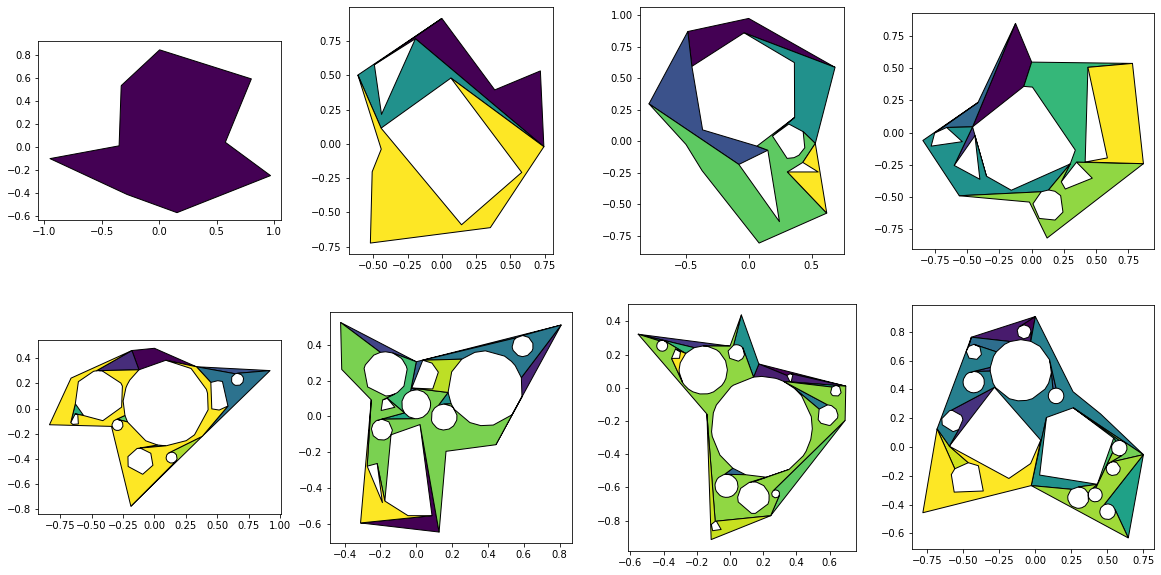

In [91]:
polys = []
imax = 4*2
fig, axs = plt.subplots(nrows = imax//4, ncols = 4, figsize = (20,10))
for i in range(imax):
    poly = createPolygonWithInteriors(n_edges=9, n_interiors=i*2, n_edges_interiors=3+i*2, regular=False, convex=False)
    polys.append(poly)
    splitted = splitAtInteriors(poly, plot=False)
    GeoSeries(splitted).plot(ax=axs.flat[i], cmap="viridis",edgecolor="black")
    


### test triangularize function

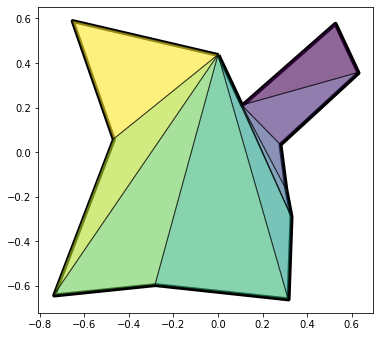

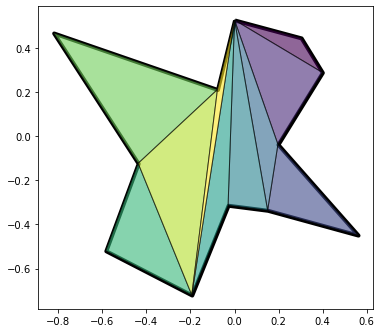

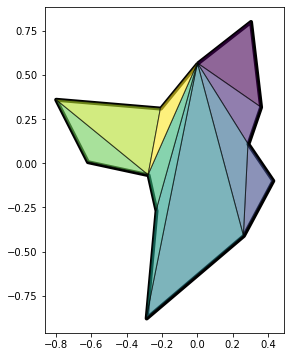

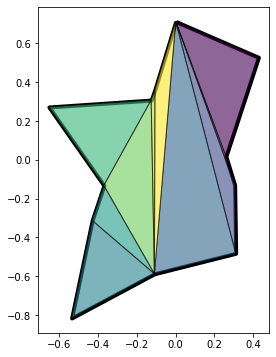

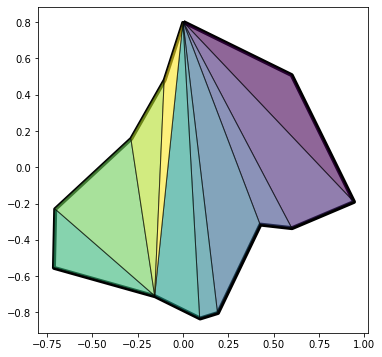

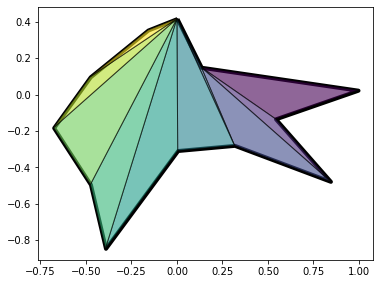

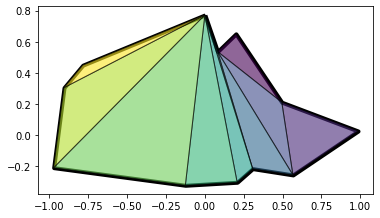

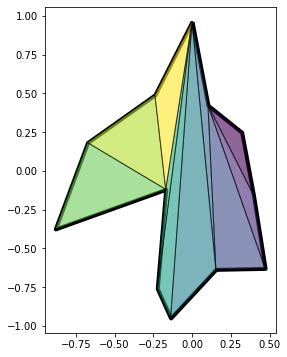

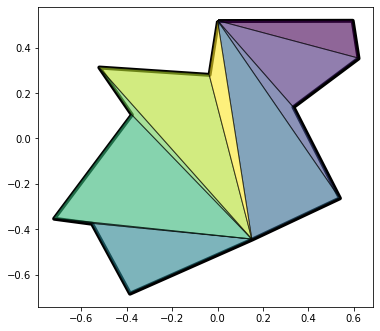

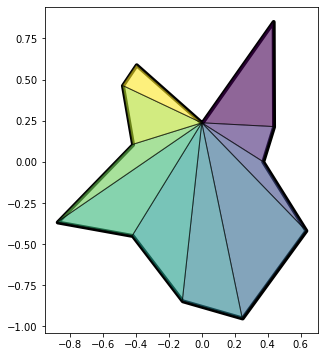

In [ ]:
for i in range(10):
    b = createPolygon(12, regular=False, convex=False)
    a = triangularize(b, plot=True)
    if not len(a) == len(b.exterior.coords)-3:
        print("not")
        triangularize(b, plot=True)
        break

### test projectConvexShadow function

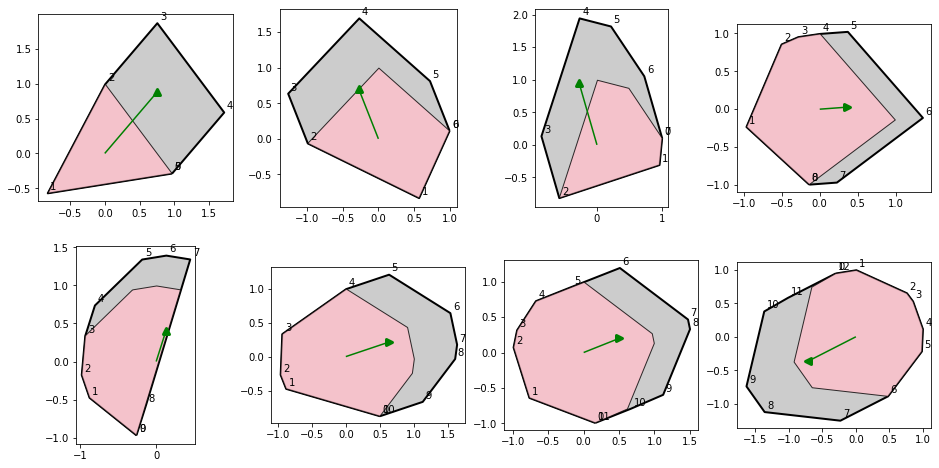

In [123]:
imax = 4*2
fig, axs = plt.subplots(nrows = imax//4, ncols = 4, figsize = (16,8))
for i in range(imax):
    triangle=createPolygon(3 + i, regular=False)
    vector = ((np.random.random()*2-1),(np.random.random()*2-1))
    shadow = projectConvexShadow(triangle.exterior.coords, vector)
    GeoSeries([shadow]).plot(ax=axs.flat[i], color="#cccccc", linewidth=2, edgecolor="black")
    GeoSeries([triangle]).plot(ax=axs.flat[i], alpha=0.8,color="pink",edgecolor="black")
    GeoSeries([LineString([(0,0),vector])]).plot(ax=axs.flat[i], edgecolor="green")
    arrow =  (">" if vector[0]>0 else "<") if abs(vector[0])>abs(vector[1]) else ("^" if vector[1]>0 else "v")
    GeoSeries([Point(vector)]).plot(ax=axs.flat[i], color="green", linewidth=3, marker = arrow)
    for x, y, label in zip([shadow.exterior.coords[x][0] for x in range(len(shadow.exterior.coords))], [shadow.exterior.coords[x][1] for x in range(len(shadow.exterior.coords))], [str(x) for x in range(len(shadow.exterior.coords))]):
        axs.flat[i].annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

### test all together
1. splitAtInteriors
2.
    - a) triangularize
    - b) splitToConvex
2. projectConvexShadow


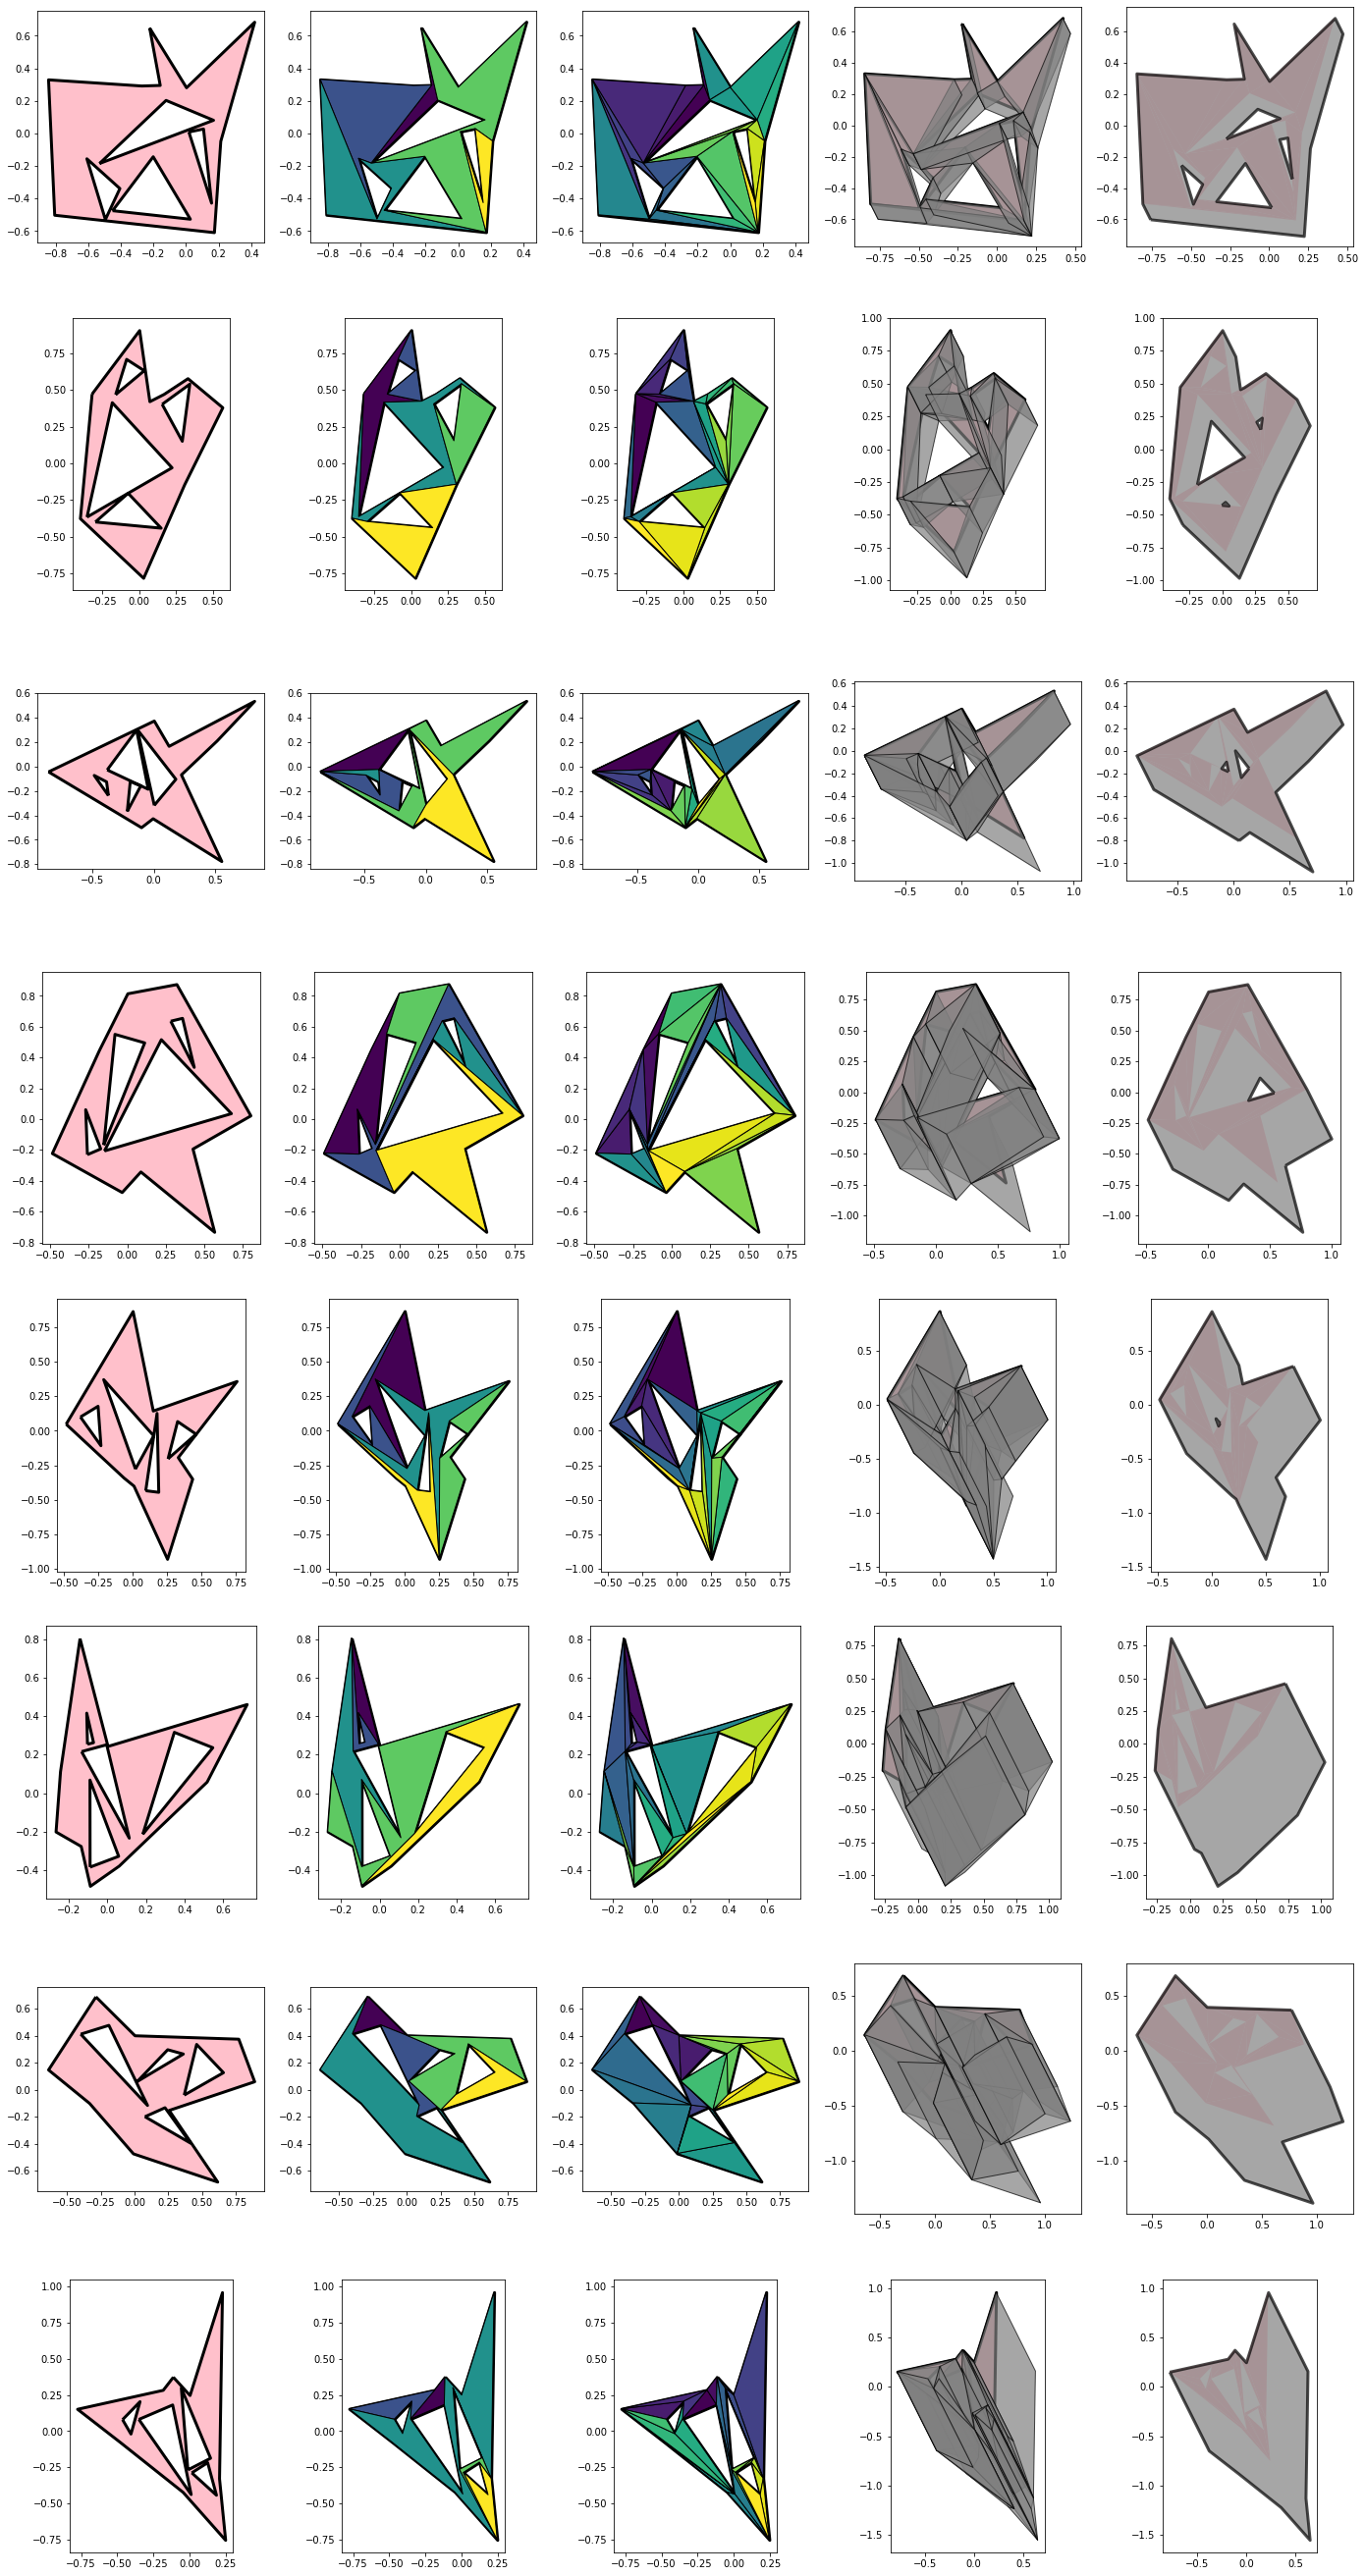

In [124]:
# polys = [x for x in smpl["geometry"].loc[10:20]]
polys = []
imax = 8
if len(polys) < 8:
    for i in range(len(polys), imax):
        poly = createPolygonWithInteriors(n_edges=9, n_interiors=4, n_edges_interiors=3, regular=False, convex=False)
        polys.append(poly) 
#
fig, axs = plt.subplots(nrows = imax, ncols = 5, figsize = (24,imax*6))
for i in range(imax):
    shadowVector = (i/20+0.05, -i/10-0.1) 
    poly = polys[i]
    splitted = splitAtInteriors(poly, plot=False)
    triangleCoords = [item for sublist in [triangularize(x, plot=False) for x in splitted] for item in sublist]
    triangles = [Polygon(x) for x in triangleCoords]
    shadows = [projectConvexShadow(x, shadowVector) for x in triangleCoords]
    shadow_union = cascaded_union(shadows)

    GeoSeries([poly]).plot(ax=axs.flat[i*5+0], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=axs.flat[i*5+1], color = "white", edgecolor="black", linewidth=3)
    GeoSeries(splitted).plot(ax=axs.flat[i*5+1], cmap="viridis",edgecolor="black")
    GeoSeries([poly]).plot(ax=axs.flat[i*5+2], color = "white", edgecolor="black", linewidth=3)
    GeoSeries(triangles).plot(ax=axs.flat[i*5+2], cmap="viridis",edgecolor="black")
    GeoSeries([poly]).plot(ax=axs.flat[i*5+3], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries(shadows).plot(ax=axs.flat[i*5+3], alpha=0.7, color = "grey",edgecolor="black")
    GeoSeries(triangles).plot(ax=axs.flat[i*5+4], color = "pink")
    GeoSeries([shadow_union]).plot(ax=axs.flat[i*5+4], alpha=0.7, color = "grey",edgecolor="black", linewidth=3)



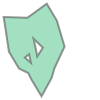

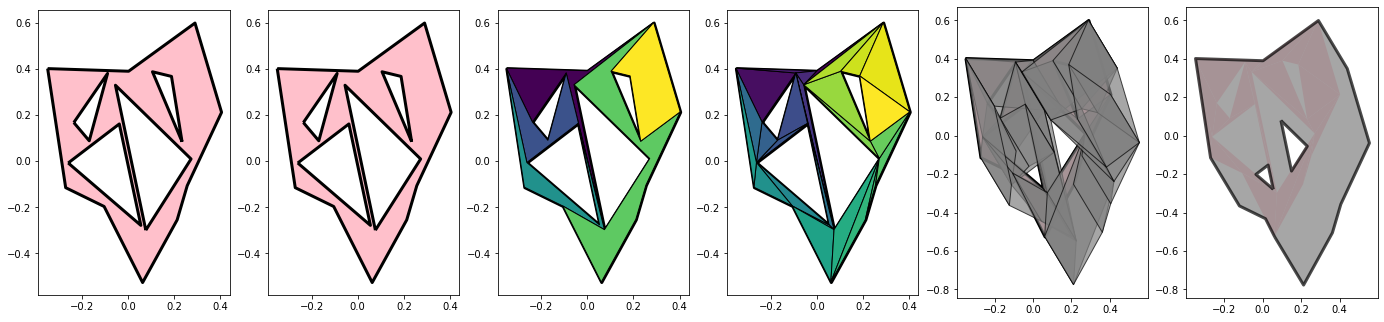

In [85]:

shadowVector = (0.15, -0.25) 
poly = createPolygonWithInteriors(n_edges=9, n_interiors=4, n_edges_interiors=3, regular=False, convex=False)
projectPolygonShadow(poly=poly, shadowVector=shadowVector, plot=True)

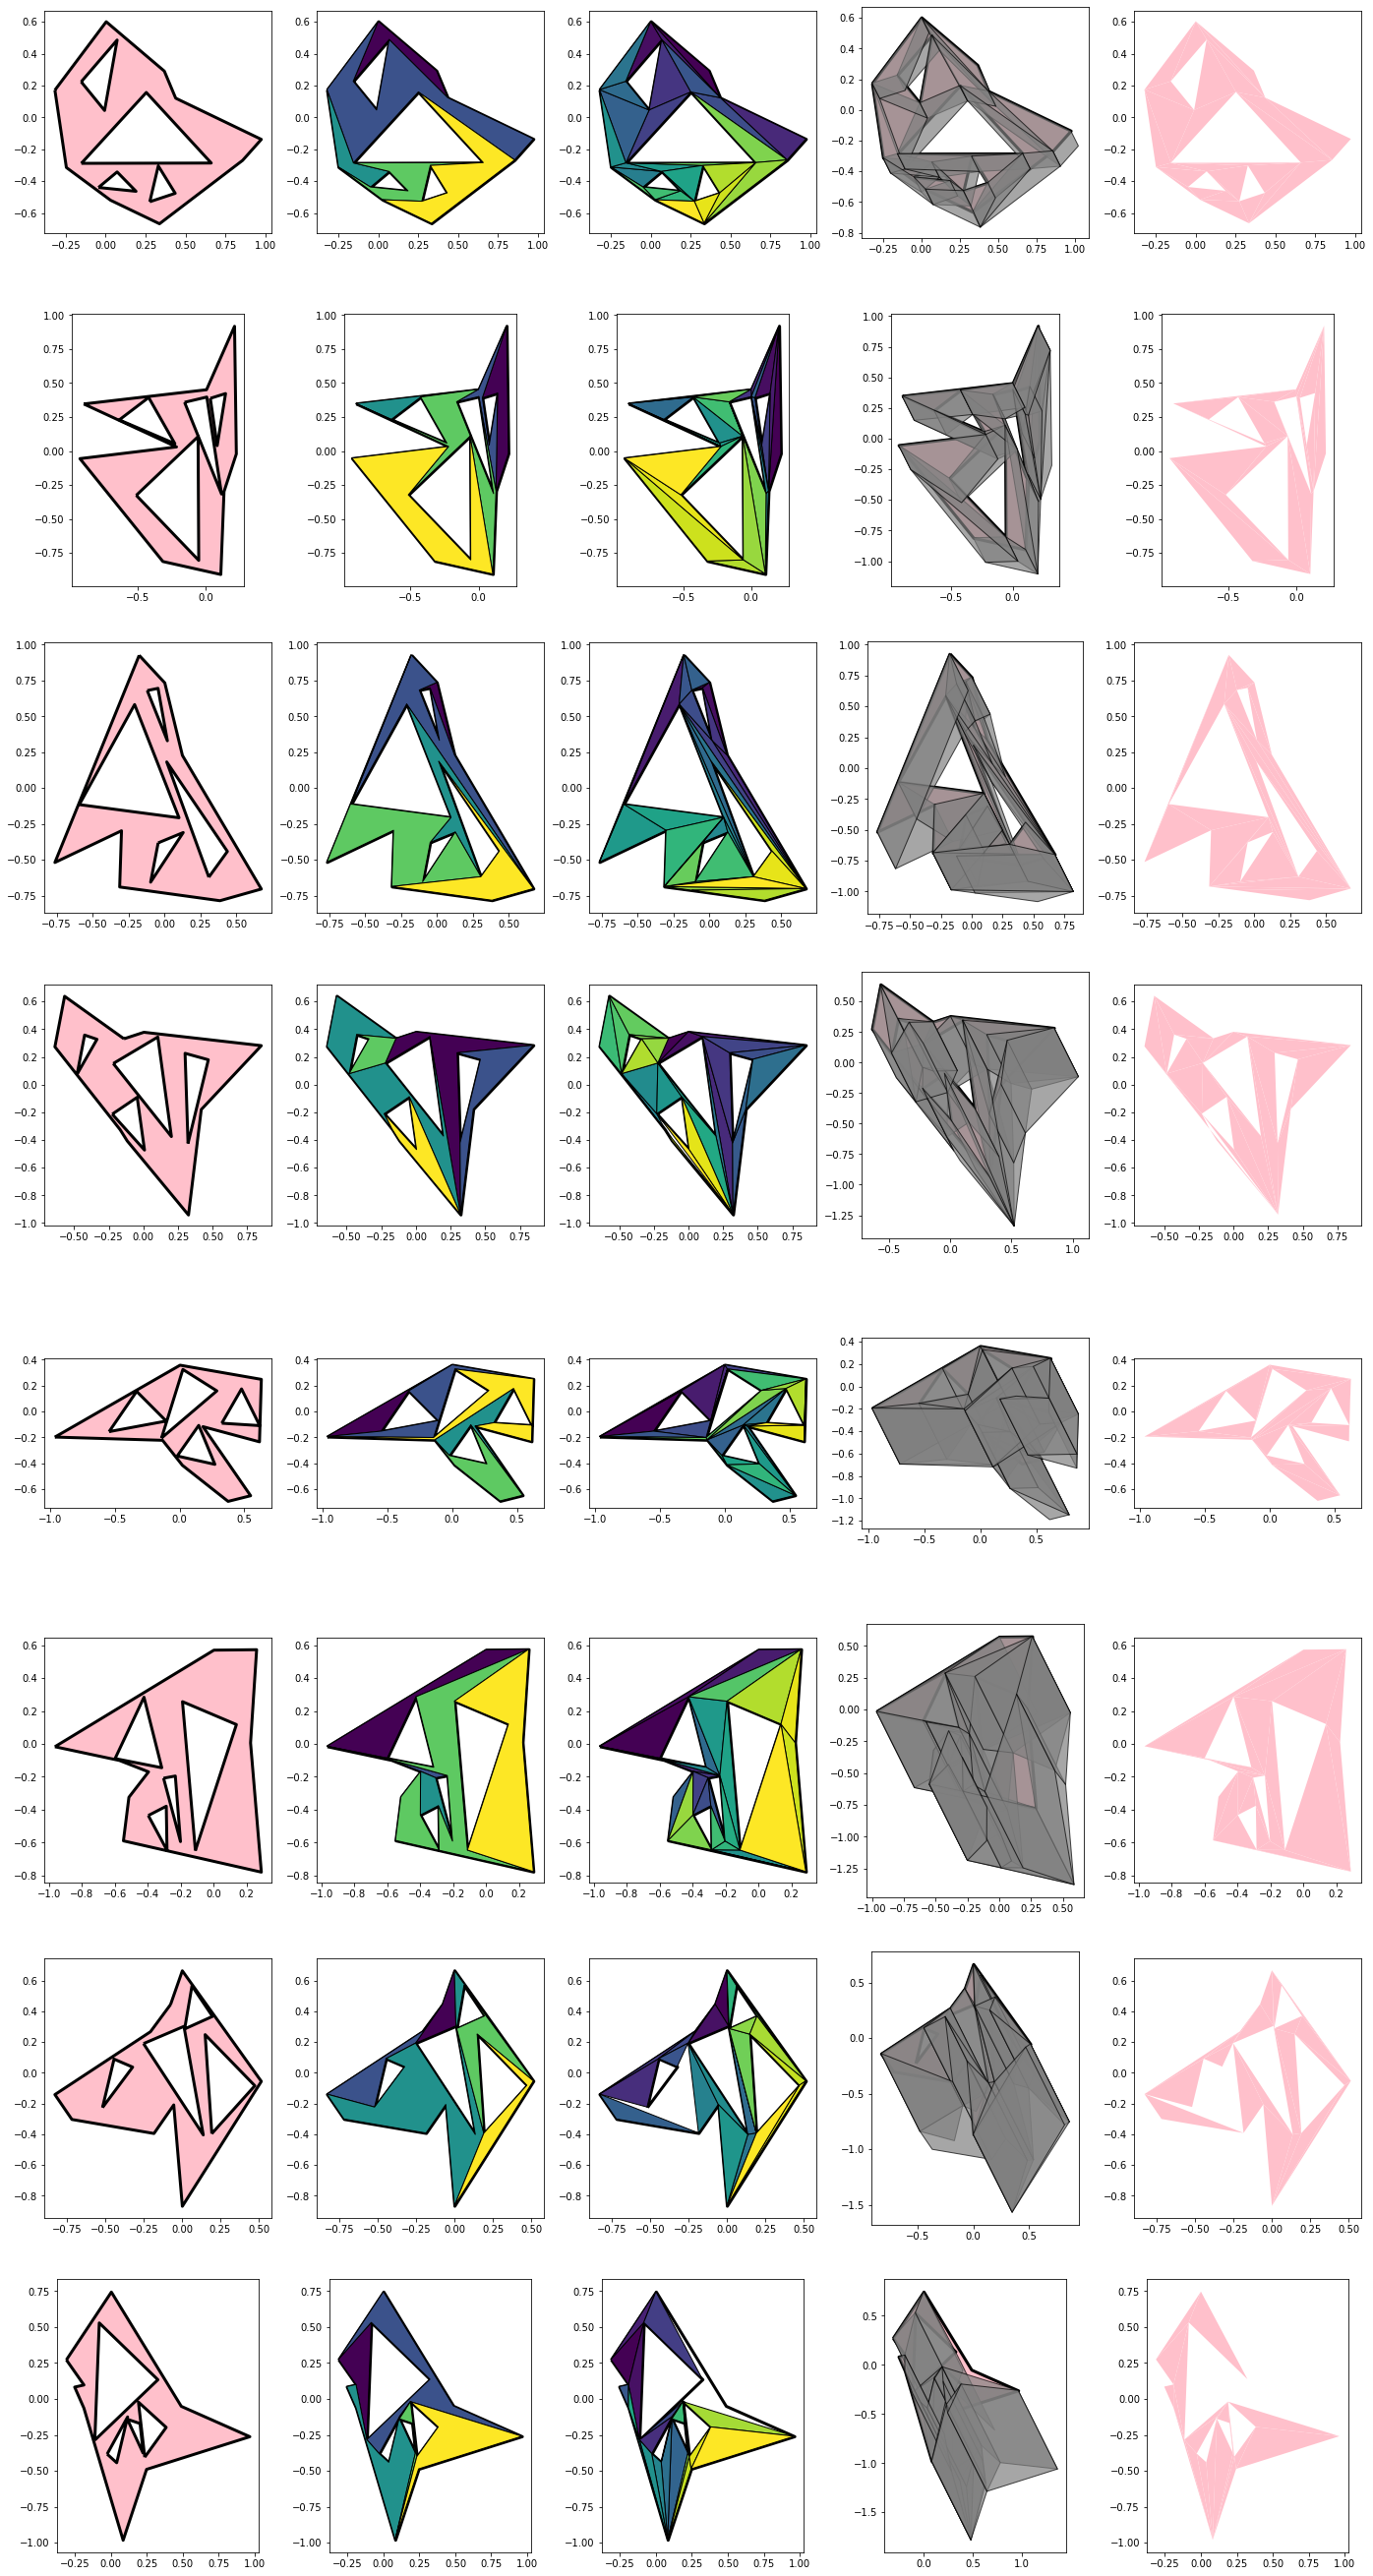

In [125]:
polys = []
imax = 8
fig, axs = plt.subplots(nrows = imax, ncols = 5, figsize = (24,imax*6))
for i in range(imax):
    shadowVector = (i/20+0.05, -i/10-0.1) 
    poly = createPolygonWithInteriors(n_edges=9, n_interiors=4, n_edges_interiors=3, regular=False, convex=False)
    polys.append(poly)
    splitted = splitAtInteriors(poly, plot=False)
    convexCoords = [item for sublist in [splitToConvex(x, plot=False) for x in splitted] for item in sublist]
    convexPolys = [Polygon(x) for x in convexCoords]
    shadows = [projectConvexShadow(x, shadowVector) for x in convexCoords]
    shadow_union = cascaded_union(shadows)

    GeoSeries([poly]).plot(ax=axs.flat[i*5+0], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=axs.flat[i*5+1], color = "white", edgecolor="black", linewidth=3)
    GeoSeries(splitted).plot(ax=axs.flat[i*5+1], cmap="viridis",edgecolor="black")
    GeoSeries([poly]).plot(ax=axs.flat[i*5+2], color = "white", edgecolor="black", linewidth=3)
    GeoSeries(convexPolys).plot(ax=axs.flat[i*5+2], cmap="viridis",edgecolor="black")
    GeoSeries([poly]).plot(ax=axs.flat[i*5+3], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries(shadows).plot(ax=axs.flat[i*5+3], alpha=0.7, color = "grey",edgecolor="black")
    GeoSeries(convexPolys).plot(ax=axs.flat[i*5+4], color = "pink")
    # GeoSeries([shadow_union]).plot(ax=axs.flat[i*5+4], alpha=0.7, color = "grey",edgecolor="black", linewidth=3)



# Apply methods to geodata
## Possible improvements:
- Don't loop through geodataframe to project shadow for each row but use a faster methods 
    (https://towardsdatascience.com/how-to-make-your-pandas-loop-71-803-times-faster-805030df4f06e) 
- Probably faster when reordering loop from datetimes -> geometries -> shadow to geometries -> datetimes -> shadow

### speed up code by 
- evaluate wheter set() makes it faster
- don't call fcts from objects like math.fun()
- Use multiple assignments like a, b, c, d = 2, 3, 5, 7
- L = [i for i in range (1, 1000) if i%3 == 0]
- Use proper data structure whereever possible

In [126]:
# Month day combinations
filenames = ["Gebaeude_Hoehen_Phase1", "Gebaeude_Hoehen_Phase2"]

filename = filenames[0]
print("open ", filename)
connection = r'./GeoData/' + filename + '.shp'
# Importing an ESRI Shapefile
footprint_df = gpd.read_file(connection)
print("file read.")

open  Gebaeude_Hoehen_Phase1
file read.


In [127]:
if("Class_name" in footprint_df.columns):
    footprint_df = footprint_df[
        (footprint_df['Mean_nDOM'] > 0) & 
        (footprint_df['Class_name'] != 'Veg < 2,5 m (einschl. Rasen, Grünland)')
    ]

footprint_df['height'] = footprint_df['Mean_nDOM']

#reproject to obtain proper WGS84 latitude-longitude projection EPSG:4326, 
# to obtain correct coordinates to retrieve altitude and azimuth
footprint_df = footprint_df.to_crs(epsg = 4326)
footprint_df['centroid'] = footprint_df.centroid
footprint_df['long4326'] = footprint_df['centroid'].x
footprint_df['lat4326'] = footprint_df['centroid'].y

# reprojecting to DHDN / Soldner Berlin EPSG:3068 with transformation: 1777
# DHDN: Deutsches Hauptdreiecksnetz
# https://epsg.io/3068-15949
footprint_df = footprint_df.to_crs(epsg = 3068)

C:\Users\BSE\AppData\Local\Temp\ipykernel_9720\380844569.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  footprint_df['centroid'] = footprint_df.centroid


In [ ]:
type()

In [130]:
footprint_df.columns

Index(['OBJECTID', 'OS', 'ALK_GEBAEU', 'AUFSCHRIFT', 'CLASS_NAME', 'ISU5_SCHL',
       'Bezirk', 'bez_nr', 'ALK_ID', 'GRUENDACH', 'Max_nDOM', 'Mean_nDOM',
       'Min_nDOM', 'ECLASS_NAM', 'EGRUENDACH', 'Shape_Leng', 'Shape_Area',
       'GESCHOSSNR', 'EGESCHOSSN', 'Geb_ID1', 'gesch_DBL', 'geometry',
       'height', 'centroid', 'long4326', 'lat4326'],
      dtype='object')

In [ ]:
sum([len(x.exterior.coords) for x in footprint_df["geometry"] if type(x)==Polygon])/len(footprint_df)

14.763166307243436

In [ ]:
# plot using GeoPandas and Matplotlib
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
fig.suptitle(filename + ': color according to mean height.')

In [ ]:
# define dates

hours = [18, 9]
daymonth = [[12,21], [3,21], [6,21], [9,21]]
# year, month, day, hour, minute, second, microsecond
# calculate angle between sun and earth surface at location and date, only use date if sun is above
dates = [item for sublist in [[datetime(2021, *mmdd, hh, 0, 0, 0, tzinfo=pytz.timezone('Europe/Berlin')) for hh in hours \
    ] for mmdd in daymonth] for item in sublist \
    if solar.get_altitude(latitude_deg = 52.5, longitude_deg = 13.4, when = item)>0]
print(len(dates))

6


In [ ]:
n = 100
smpl = footprint_df[10:10+n]
startTime = datetime.now()
a = smpl.apply(lambda row: \
    [\
            cascaded_union(\
                [projectConvexShadow(\
                    triangle, \
                    stored[1]\
                ) for triangle in stored[0][0]\
            ])\
            for date in dates
    for stored in [[getTriangleCoords(row['geometry']),getShadowVector(row['lat4326'], row['long4326'], date, row['height'])]]\
    ], axis=1)

endTime = datetime.now()
print(datetime.now() - startTime, "time spent for ", n, "objects at ", len(dates), "timepoints totaling in ",n*len(dates), " shadow projections. each:", (datetime.now() - startTime)/n*len(dates))
print("total time will be approx", (datetime.now() - startTime)*600000/n)

0:00:06.739185 time spent for  100 objects at  6 timepoints totaling in  600  shadow projections. each: 0:00:00.404352
total time will be approx 11:14:01.104000


In [ ]:
n = 10
smpl = footprint_df[10:10+n]
startTime = datetime.now()
a = smpl.apply(lambda row: \
    [\
            cascaded_union(\
                [projectConvexShadow(\
                    convexPoly, \
                    stored[1]\
                ) for convexPoly in stored[0][0]\
            ])\
            for date in dates
    for stored in [[getConvexCoords(row['geometry'], triangleMethod=False),getShadowVector(row['lat4326'], row['long4326'], date, row['height'])]]\
    ], axis=1)

endTime = datetime.now()
print(datetime.now() - startTime, "time spent for ", n, "objects at ", len(dates), "timepoints totaling in ",n*len(dates), " shadow projections. each:", (datetime.now() - startTime)/n*len(dates))

0:00:34.003915 time spent for  10 objects at  6 timepoints totaling in  60  shadow projections. each: 0:00:20.402352


In [ ]:
len(smpl)

10

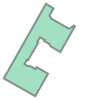

In [ ]:
smpl["geometry"].loc[13]

In [ ]:
len(triangularize(smpl["geometry"].loc[i], plot=False))

27

In [ ]:
len(splitToConvex(smpl["geometry"].loc[i], plot=False))

17

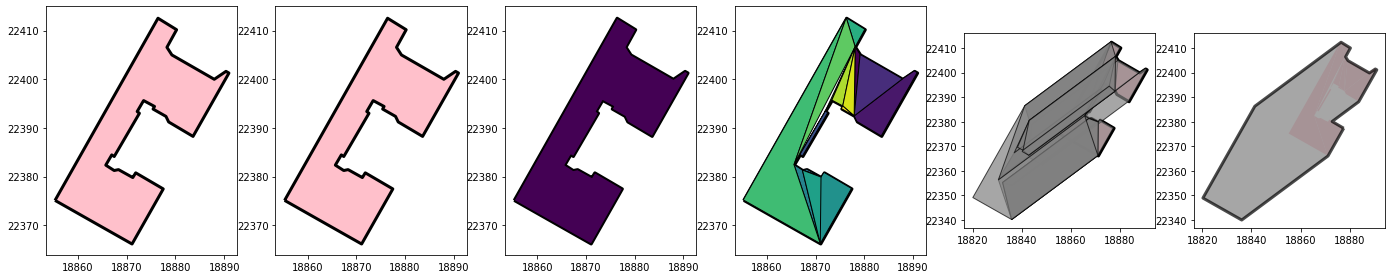

In [ ]:
i = 13
a2=projectPolygonShadow(smpl["geometry"].loc[i], getShadowVector(smpl['lat4326'].loc[i], smpl['long4326'].loc[i], dates[2], smpl['height'].loc[i]), plot=True)

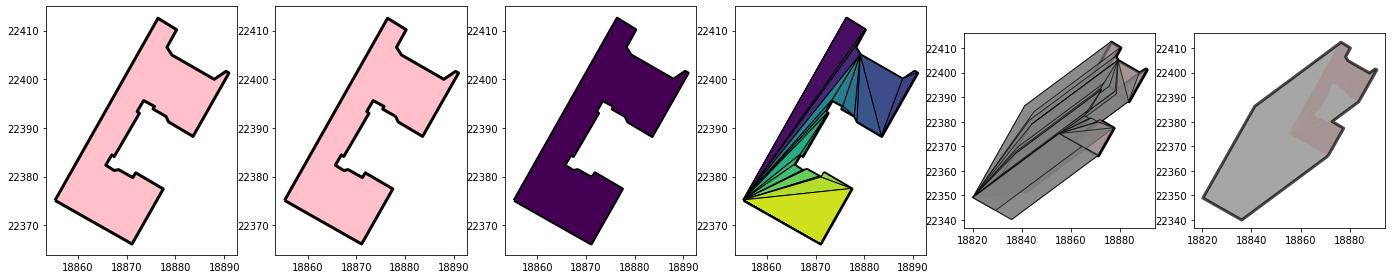

In [ ]:
i = 13
a1 = projectPolygonShadow(smpl["geometry"].loc[i], getShadowVector(smpl['lat4326'].loc[i], smpl['long4326'].loc[i], dates[2], smpl['height'].loc[i]), plot=True, triangleMethod=True)

In [ ]:
a1.equals(a2)

True

In [ ]:


shadow_df = smpl


[[(a,c) for c in range(2) ] for a in [b for b in range(4)]]
[[(a,c) for c in range(2) ] for a in [b for b in [range(4)]]]
[cascaded_union([projectConvexShadow(tc, getShadowVector(row['lat4326'], row['long4326'], date, row['height']))\
    for date in dates]) for tc in [getTriangleCoords(row['geometry'], triangleMethod=True)]]

smpl.apply(lambda row: \
    [cascaded_union([projectConvexShadow(tc, getShadowVector(row['lat4326'], row['long4326'], date, row['height']))\
    for date in dates]) for tc in [getTriangleCoords(row['geometry'], triangleMethod=True)]]\
    )




progress = list(map(lambda x: (len(smpl)/100*x)//1, range(1,101)))
startTime = lastTime =  datetime.now()
leftOvers = smpl.index if not 'i' in locals() else smpl.index[i:]
for i in range(len(smpl)):
# for i in smpl.index:
    geom = smpl.loc[i, 'geometry']#, 
    height = smpl.loc[i, 'height']#,
    lat = smpl.loc[i, 'lat4326']#, 
    long = smpl.loc[i, 'long4326']#
    showPlots = False

    if(type(geom) != shapely.geometry.polygon.Polygon):
        continue
    #

    triangleCoords = getTriangleCoords(geom, triangleMethod=True)

    for mmdd in dates:
        for hh in hours:
            shadowVector = getShadowVector(lat, long, date, height)
            shadowGeom = cascaded_union([projectConvexShadow(tc, shadowVector) for tc in triangleCoords])
            
    shadow_df.loc[i, "geometry"] = shadow
    if(i in progress):
        print(progress.index(i), "%. Time: ",  datetime.now() - lastTime)
        lastTime = datetime.now()
    #
    # save as new file
    newFileName = str(filename)+"_"+str(mmdd[0])+"-"+str(mmdd[1])+"_"+str(hh)+".shp"
    print("save to ", newFileName)
shadow_df.to_file(newFileName)   



open  Gebaeude_Hoehen_Phase1


KeyboardInterrupt: 

In [ ]:
oneShadowGeom = cascaded_union(shadow_df["geometry"])
    
# plot using GeoPandas and Matplotlib
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
shadow_df.plot(ax=axs, color =  "#ccccccaa")
footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
fig.suptitle(filename + 'color according to mean height.')
print('Overall time for shadow projection: ', datetime.now() - startTime)

In [ ]:
i

0

### Merge shadow map into single multipolygon
This can reduce memory space and make operations faster where you check wheter point is within shadow or not

In [ ]:
# %% merge and simplify polygons 

for i in footprint_df.index:
    if(i in progress):
        print(progress.index(i), "%. Time: ",  datetime.now() - lastTime)
        lastTime = datetime.now()
#
                #
                
a = list(map(lambda x: type(x), shadow_df['geometry']))
from itertools import groupby
[len(list(group)) for key, group in groupby(a)]

from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry
df = GeoSeries([geom])
df.crs = "EPSG:3068"
df = df.to_crs(4326)
poly = geom#Polygon([(0, 0), (0, 1), (1, 1), (0, 0)])

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open('./out/'+newFileName+'ONE'+'.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(oneShadowGeom),
        'properties': {'id': newFileName},
    })

# Intersecting Layers intersection = gpd.overlay(layer1, layer2, how = 'intersection')
# Union Layers union = gpd.overlay(layer1, layer2, how = 'union')
# how = [
#   'symmetric_difference'= A|B & !A&B, 
#   'difference' = A & !B, 
#   'dissolve' = merge, 
#       first give union common variable with same value union['common_column'] = 1
#       disolve: union_desolved = union.dissolve(by='commun_column')

# shapely:: object.simplify(tolerance, preserve_topology=True) Returns a simplified representation of the geometric object.

# https://geopandas.org/docs/user_guide/geometric_manipulations.html
# https://geopandas.org/docs/user_guide/data_structures.html
# districts_in_aoi['area'] = districts_in_aoi.area/1000000

# Exporting GeoPandas GeoDataFrames into an ESRI Shapefile
# districts_in_aoi.to_file('districts_within_aoi.shp', driver = "ESRI Shapefile")

# Create figures for illustration of method on how shadows are computed

### Shadow of a pole for each date time combination

2021-12-21 09:00:00+00:53 alt 4.968453323647629 az 139.9311296111179 xy (-7.404569127865242, -8.802911224994974)
2021-12-21 10:00:00+00:53 alt 9.947166071368224 az 152.83114086127446 xy (-2.603626321579327, -5.072888877632681)
2021-12-21 11:00:00+00:53 alt 13.09999582116685 az 166.48614954966123 xy (-1.0041820841237017, -4.178269546050155)
2021-12-21 12:00:00+00:53 alt 14.122510604458734 az 180.5937707988098 xy (0.04118861465078254, -3.974343811259648)
2021-12-21 13:00:00+00:53 alt 12.914666081747502 az 194.68027052752612 xy (1.1052109432217796, -4.218731463062634)
2021-12-21 14:00:00+00:53 alt 9.594387122161537 az 208.2803173661529 xy (2.8028591531159557, -5.209761021572769)
2021-12-21 15:00:00+00:53 alt 4.48430024970514 az 221.11108657896716 xy (8.383967295005865, -9.606968952112508)
2021-03-21 07:00:00+00:53 alt 8.462325090891232 az 100.47136878295683 xy (-6.6094474205769895, -1.2215727350886183)
2021-03-21 08:00:00+00:53 alt 17.157123425383762 az 112.98374639212787 xy (-2.981926371

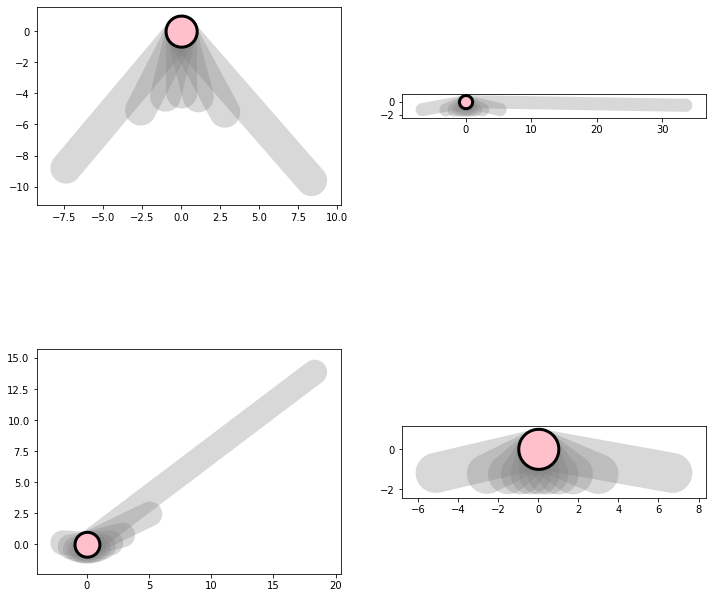

In [ ]:
pole=createPolygon(100)
hours = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
daymonth = [[12,21], [3,21], [6,21], [9,21]]
# year, month, day, hour, minute, second, microsecond
# calculate angle between sun and earth surface at location and date, only use date if sun is above
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12))
for i in range(4):
    dates = [item for sublist in [[datetime(2021, *mmdd, hh, 0, 0, 0, tzinfo=pytz.timezone('Europe/Berlin')) for hh in hours \
    ] for mmdd in [daymonth[i]]] for item in sublist \
    if solar.get_altitude(latitude_deg = 52.5, longitude_deg = 13.4, when = item)>0]
    shadows = \
        [\
            cascaded_union(\
                [projectConvexShadow(\
                triangle, \
                stored[1]\
                ) for triangle in stored[0][0]\
                ])\
            for date in dates
            for stored in [[getTriangleCoords(pole, triangleMethod=True),getShadowVector(52.5, 13.4, date, 1)]]\
        ]


    GeoSeries(shadows).plot(ax=axs.flat[i], alpha=0.3, color = "grey")
    GeoSeries([pole]).plot(ax=axs.flat[i], color = "pink",edgecolor="black", linewidth=3)

